## Evaluate ability of GPT3 to estimate prices

In [1]:
import os
import openai
import pandas as pd
import sklearn
from sklearn.metrics import mean_absolute_error,f1_score,accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
openai.api_key = os.getenv("OPENAI_API_KEY")

def orderOfMagnitude(number):
    try:
        order=math.floor(math.log(number, 10))
    except:
        order=None
    return order

### Prepare requests

In [2]:
df=pd.read_csv("../input_data/costs.csv")


df['query']=df['query'].str.lower().replace("average","",regex=True).str.lstrip(" ")

df=df.dropna().reset_index(drop=True)

In [3]:
df.shape

(50, 2)

### Ask for prices

In [4]:
for i,d in df.iterrows():
    prompt="What is the average "+d['query']+"? (Respond with a dollar amount.)"
    response = openai.Completion.create(engine="text-davinci-002", prompt=prompt,temperature=0,max_tokens=60)
    response_text=response.choices[0].text
    df.loc[i,'GPT3_estimation']=response_text
    print(prompt)
    print(response_text)
    print("Ground truth",d['in USD'])
    print("################################")

What is the average fine for jaywalking? (Respond with a dollar amount.)


There is no definitive answer to this question as fines for jaywalking vary depending on the municipality. However, a quick search online reveals that the average fine for jaywalking in the United States is around $50.
Ground truth 1.0
################################
What is the average cost of a cup of coffee? (Respond with a dollar amount.)


$2.75
Ground truth 5.0
################################
What is the average cost of painting a mailbox? (Respond with a dollar amount.)


$50
Ground truth 20.0
################################
What is the average cost of painting a front door? (Respond with a dollar amount.)


The average cost of painting a front door is $100.
Ground truth 150.0
################################
What is the average cost of repairing a house window? (Respond with a dollar amount.)


The average cost of repairing a house window is $100.
Ground truth 200.0
################################
Wh

What is the average value of a pet dog? (Respond with a dollar amount.)


The average value of a pet dog is $1,000.
Ground truth 100000.0
################################
What is the average value of an old teddy bear? (Respond with a dollar amount.)


There is no definitive answer to this question as the value of an old teddy bear depends on a number of factors, including its condition, age, and rarity. Generally speaking, however, an old teddy bear is likely to be worth anywhere from $20 to $200.
Ground truth 1000.0
################################
What is the average value of a diamond necklace passed down for generations? (Respond with a dollar amount.)


The average value of a diamond necklace passed down for generations is $5,000.
Ground truth 250000.0
################################
What is the average value of a pet fish? (Respond with a dollar amount.)


The average value of a pet fish is $5.
Ground truth 500.0
################################
What is the average cost of eye 

### Format response

In [6]:
df['parsed_score']=df.GPT3_estimation.str.extract('(\d+[,\d]*[.*\d]+)')
df['parsed_score']=df.parsed_score.replace(",","",regex=True)
df['parsed_score']=pd.to_numeric(df['parsed_score'])

In [7]:
df.corr()

,in USD,parsed_score
in USD,1.00000,0.17614
parsed_score,0.17614,1.00000


### Measure magnitudes

In [8]:
df=df.assign(magnitude_gpt3=df.parsed_score.apply(orderOfMagnitude))
df=df.assign(magnitude=df['in USD'].apply(orderOfMagnitude))

df_mae=df.dropna()

## for this one the response was per square foot
df_mae=df_mae.loc[~df_mae['query'].isin(['cost of sodding a lawn'])]

print("MAE: ",mean_absolute_error(df_mae['magnitude'], df_mae.magnitude_gpt3))

MAE:  0.7111111111111111


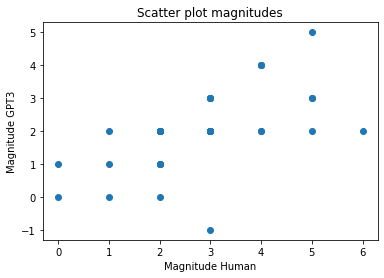

In [10]:
plt.scatter(df['magnitude'],df.magnitude_gpt3)
plt.title("Scatter plot magnitudes")
plt.ylabel("Magnitude GPT3")
plt.xlabel("Magnitude Human")
plt.show()

In [12]:
df_mae=df_mae.loc[:,['query','in USD','parsed_score','magnitude','magnitude_gpt3']]

In [13]:
df_mae.to_csv("../outputs/analysis/responses_gpt3_prices.csv",index=False)